In [1]:
import os
import torch

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

import transformers
import textwrap
from transformers import LlamaTokenizer, LlamaForCausalLM

import sys
from typing import List

from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)

import fire

from datasets import load_dataset
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import json
import numpy as np
import wandb

Using device: cuda


/home/user/ishfaqm0/miniconda3/envs/nlp2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/user/ishfaqm0/miniconda3/envs/nlp2/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /home/user/ishfaqm0/miniconda3/envs/nlp2/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /home/user/ishfaqm0/miniconda3/envs/nlp2/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...
[2023-07-04 20:09:04,541] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if random_seed is None:
        random_seed = 13
    os.environ["PY/THONHASHSEED"] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)


set_random_seed(42)

### Data

In [11]:
sarcasm_df = pd.read_csv("data/train-balanced-sarcasm.csv")

In [12]:
sarcasm_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [13]:
# We just need comment & label columns
# So, let's remove others.
sarcasm_df.drop(
    [
        "author",
        "subreddit",
        "score",
        "ups",
        "downs",
        "date",
        "created_utc",
        "parent_comment",
    ],
    axis=1,
    inplace=True,
)
# remove empty rows
sarcasm_df.dropna(inplace=True)

# Some comments are missing, so we drop the corresponding rows.
sarcasm_df.dropna(subset=["comment"], inplace=True)

In [14]:
sarcasm_df["label"].value_counts()

label
0    505403
1    505368
Name: count, dtype: int64

In [15]:
# Calculate the lengths of comments
comment_lengths = [len(comment.split()) for comment in sarcasm_df["comment"]]

# Calculate the mean, maximum, and minimum lengths
mean_length = sum(comment_lengths) / len(comment_lengths)
max_length = max(comment_lengths)
min_length = min(comment_lengths)

# Print the results
print("Mean length:", mean_length)
print("Maximum length:", max_length)
print("Minimum length:", min_length)

Mean length: 10.461467533199905
Maximum length: 2222
Minimum length: 1


In [16]:
# Filter the dataframe to keep only comments with length <= 50
mask = [length <= 50 for length in comment_lengths]
sarcasm_df = sarcasm_df[mask]

# Reset the index of the dataframe
sarcasm_df.reset_index(drop=True, inplace=True)

In [17]:
# Calculate the lengths of comments
comment_lengths = [len(comment.split()) for comment in sarcasm_df["comment"]]

# Calculate the mean, maximum, and minimum lengths
mean_length = sum(comment_lengths) / len(comment_lengths)
max_length = max(comment_lengths)
min_length = min(comment_lengths)

# Print the results
print("Mean length:", mean_length)
print("Maximum length:", max_length)
print("Minimum length:", min_length)

Mean length: 10.265359705412772
Maximum length: 50
Minimum length: 1


In [18]:
sarcasm_df.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [19]:
sarcasm_df["label"].value_counts()

label
1    504617
0    503166
Name: count, dtype: int64

<Axes: xlabel='label'>

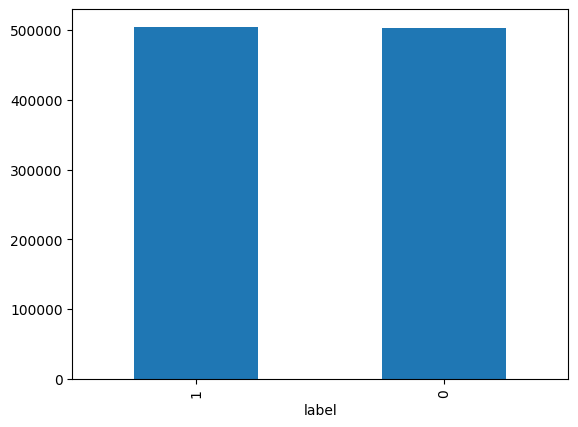

In [21]:
sarcasm_df["label"].value_counts().plot(kind="bar")

### Build JSON Dataset

In [23]:
def label_to_name(label):
    if label == 1:
        return "Sarcastic"
    return "Not Sarcastic"


dataset_data = [
    {
        "instruction": "Detect if the comment is sarcastic or not.",
        "input": row_dict["comment"],
        "output": label_to_name(row_dict["label"]),
    }
    for row_dict in sarcasm_df.to_dict(orient="records")
]

In [24]:
dataset_data[0]

{'instruction': 'Detect if the comment is sarcastic or not.',
 'input': 'NC and NH.',
 'output': 'Not Sarcastic'}

In [25]:
with open("sarcasm-dataset-alpaca.json", "w") as f:
    json.dump(dataset_data, f)

### Model Weights

In [4]:
BASE_MODEL = "decapoda-research/llama-7b-hf"

model = LlamaForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="balanced",
)

tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)

tokenizer.pad_token_id = 0  # unk. we want this to be different from the eos token
tokenizer.padding_side = "left"

Loading checkpoint shards: 100%|██████████| 33/33 [00:15<00:00,  2.08it/s]
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


### Dataset

In [5]:
data = load_dataset("json", data_files="sarcasm-dataset-alpaca.json")

Found cached dataset json (/home/user/ishfaqm0/.cache/huggingface/datasets/json/default-d18af4156e32a0a3/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
100%|██████████| 1/1 [00:00<00:00, 73.70it/s]


In [6]:
data["train"]

Dataset({
    features: ['instruction', 'output', 'input'],
    num_rows: 1007783
})

In [6]:
CUTOFF_LEN = 256

In [7]:
def generate_prompt(data_point):
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.  # noqa: E501
### Instruction:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Response:
{data_point["output"]}"""

In [8]:
def tokenize(prompt, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=CUTOFF_LEN,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < CUTOFF_LEN
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result


def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenize(full_prompt)
    return tokenized_full_prompt

In [9]:
train_val = data["train"].train_test_split(test_size=0.25, shuffle=True, seed=42)
train_data = train_val["train"].shuffle().map(generate_and_tokenize_prompt)
val_data = train_val["test"].shuffle().map(generate_and_tokenize_prompt)

Loading cached split indices for dataset at /home/user/ishfaqm0/.cache/huggingface/datasets/json/default-d18af4156e32a0a3/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-a5b94b5b4dfc51ec.arrow and /home/user/ishfaqm0/.cache/huggingface/datasets/json/default-d18af4156e32a0a3/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-e6ac80fcf5a4bbe7.arrow
Loading cached shuffled indices for dataset at /home/user/ishfaqm0/.cache/huggingface/datasets/json/default-d18af4156e32a0a3/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-ced8f71d4e2ad9f0.arrow
Loading cached processed dataset at /home/user/ishfaqm0/.cache/huggingface/datasets/json/default-d18af4156e32a0a3/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-e932a45aa204c7bd.arrow
Loading cached shuffled indices for dataset at /home/user/ishfaqm0/.cache/huggingface/datasets/json/default-d18af4156e32a0a3/0.0.0/8bb11242116d547c741b2e8a1f

In [9]:
# save train and val data
train_data.save_to_disk("train_data")
val_data.save_to_disk("val_data")

In [10]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: faizi-ch. Use `wandb login --relogin` to force relogin


True

In [11]:
wandb.init(
    project="sarcasm-detection",
    name="alpaca-128-batch-no-gradient-accumulation-batch-64",
)

In [69]:
%env WANDB_PROJECT=Sarcasm-Detection

env: WANDB_PROJECT=Sarcasm-Detection


In [12]:
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.05
LORA_TARGET_MODULES = [
    "q_proj",
    "v_proj",
]

BATCH_SIZE = 1024
MICRO_BATCH_SIZE = 64
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
LEARNING_RATE = 3e-4
TRAIN_STEPS = 300
OUTPUT_DIR = "experiments"

In [13]:
model = prepare_model_for_int8_training(model)
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

/home/user/ishfaqm0/miniconda3/envs/nlp2/lib/python3.10/site-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


### Training

In [14]:
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    # gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=100,
    # max_steps=TRAIN_STEPS,
    num_train_epochs=1,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=10,
    optim="adamw_torch",
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    save_steps=500,
    output_dir=OUTPUT_DIR,
    # save_total_limit=3,
    load_best_model_at_end=True,
    report_to="wandb",
    run_name="alpaca-128-batch-no-gradient-accumulation-batch-64",
    dataloader_num_workers=16,
    seed=42,
)

In [15]:
data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)

In [16]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=training_arguments,
    data_collator=data_collator,
)
model.config.use_cache = False
old_state_dict = model.state_dict
model.state_dict = (
    lambda self, *_, **__: get_peft_model_state_dict(self, old_state_dict())
).__get__(model, type(model))

model = torch.compile(model)

trainer.train()
model.save_pretrained(OUTPUT_DIR)

/home/user/ishfaqm0/miniconda3/envs/nlp2/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
500,0.661400,0.637272
1000,2.127300,2.336339
1500,2.128100,2.336339


/home/user/ishfaqm0/miniconda3/envs/nlp2/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/user/ishfaqm0/miniconda3/envs/nlp2/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/user/ishfaqm0/miniconda3/envs/nlp2/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
